# Portrait Photo Generator

In this notebook we are going to use image segmentation model(facebook/detr-resnet-50-panoptic) to generate portrait photo of any object present in a photo.

**Protrait Image Generation Steps:**
- Load segmentation model, pass your image, generate the masks and labels for each object present in the image.
- Make a list of objects from the "label" keys in the prediction dictionaries.
- Add a number identifier so that each object name can be unique. This is important for selecting a object.
- Image segmentation and background blurring method for selected object in the image:
    - Take the mask provided by the segmentation model in the earlier stage.
    - Divide by 255 to make the range 0 to 1.
    - At this point the mask is 1 channel. Make it three channel by coping the single channel three times.
    - Element wise multiply the input image and the three channel mask. 
    This will give an image where only the segmented part of the image will be present. This means, only the selected object pixels will be intact and other pixels will be black (0).
    - Now, take the original image and blur it using any kind of blurring kernel. Here I used Gaussian Blur.
    - After that, create a invert of the three channel mask created the previous steps.
    - Element wise multiply the invert mask and blurred image. 
    This will give an image where the blurred background of the selected object will be present and 
    the pixels associate with the object of interest will be blank/black/value=0.
    - Then, add up the segmented image and reverse segmented (blurred background portion). 
    This will give the desired portrait photo looking output.
    - Smoothen the image.

## Imports

In [1]:
# Imports
from PIL import Image, ImageFilter
import numpy as np
from transformers import pipeline

c:\Users\koushik\miniconda3\envs\hugging_face\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model Declaration

> "facebook/detr-resnet-50-panoptic" model has been used from hugging face hub. Link: https://huggingface.co/facebook/detr-resnet-50-panoptic

In [2]:
# Image segmentation model from hugging face hub
model = pipeline("image-segmentation", model="facebook/detr-resnet-50-panoptic")

# Expected output format
#[{'label': 'cat',
#  'mask': mask_code,
#  'score': 0.999}
# ...]

## Loading Image and Getting Prediction

> Image need to be "image path", "pil image" or "image link".

In [3]:
image = Image.open("test_images/woman_and_dog.jpg", mode='r')

In [4]:
# Output of the model
import time 
t1=time.time()
pred = model(image)
t2=time.time()
print(t2-t1)
pred

5.543190956115723


[{'score': 0.9944221377372742,
  'label': 'LABEL_200',
  'mask': <PIL.Image.Image image mode=L size=1280x853>},
 {'score': 0.9847767353057861,
  'label': 'curtain',
  'mask': <PIL.Image.Image image mode=L size=1280x853>},
 {'score': 0.9997981190681458,
  'label': 'dog',
  'mask': <PIL.Image.Image image mode=L size=1280x853>},
 {'score': 0.9889498353004456,
  'label': 'person',
  'mask': <PIL.Image.Image image mode=L size=1280x853>},
 {'score': 0.9938516616821289,
  'label': 'wall-brick',
  'mask': <PIL.Image.Image image mode=L size=1280x853>},
 {'score': 0.9922662377357483,
  'label': 'floor-wood',
  'mask': <PIL.Image.Image image mode=L size=1280x853>}]

> Let's extract the object list and add an identifier at the beginning.

In [5]:
pred_object_list = [str(i)+'_'+x['label'] for i, x in enumerate(pred)]
pred_object_list

['0_LABEL_200',
 '1_curtain',
 '2_dog',
 '3_person',
 '4_wall-brick',
 '5_floor-wood']

## Portrait Photo Generation

### Image Segmentation

> Take the mask provided by the segmentation model in the earlier stage

> Divide by 255 to make the range 0 to 1

In [6]:
mask_array = np.asarray(pred[2]['mask'])/255
image_array = np.asarray(image)

> At this point the mask is 1 channel. Make it three channel by coping the single channel three times

In [7]:
mask_array_three_channel = np.zeros_like(image_array)
mask_array_three_channel[:,:,0] = mask_array
mask_array_three_channel[:,:,1] = mask_array
mask_array_three_channel[:,:,2] = mask_array

> Element wise multiply the input image and the three channel mask. This will give an image where only the segmented part of the image will be present. This means, only the selected object pixels will be intact and other pixels will be black (0).

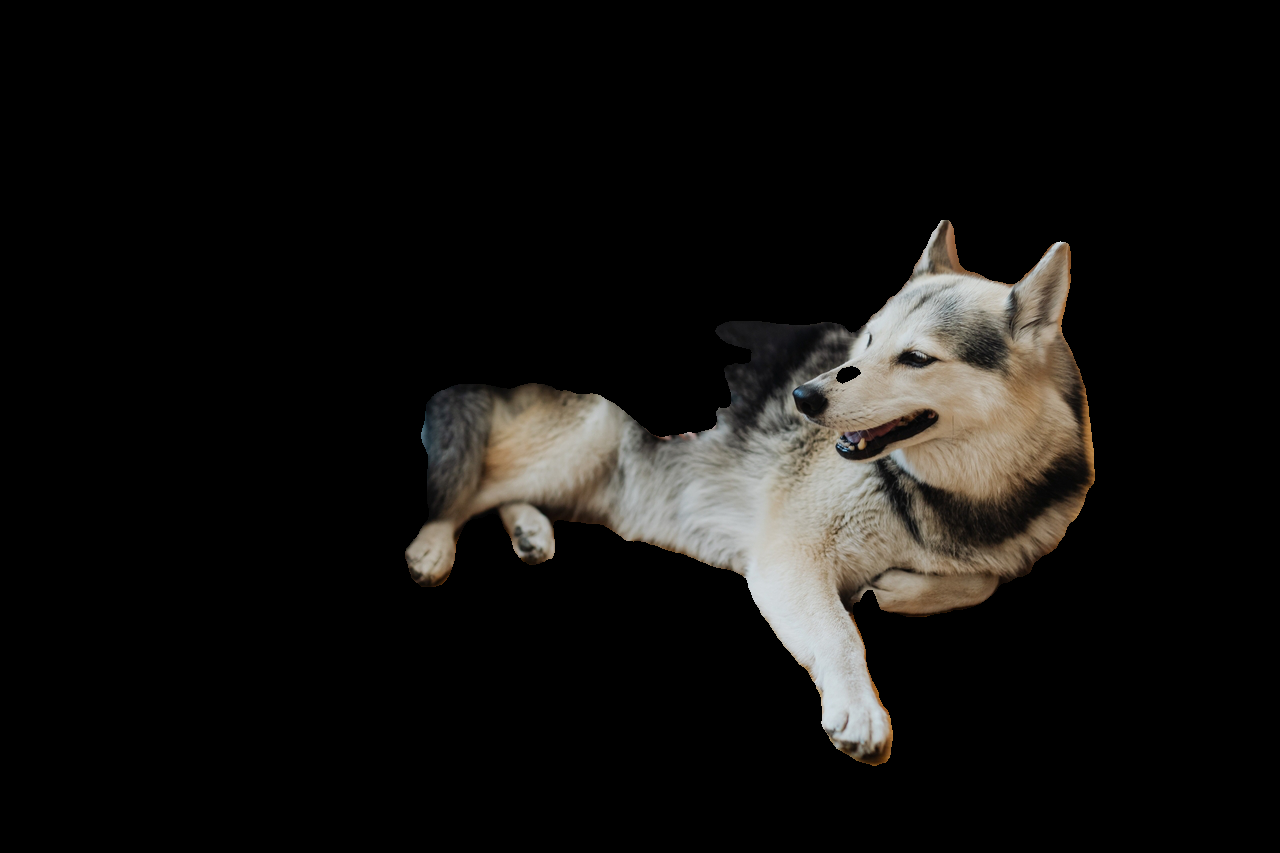

In [8]:
segmented_image = image_array*mask_array_three_channel
display(Image.fromarray(segmented_image.astype(np.uint8)))

### Image Background Blurring

> Now, take the original image and blur it using any kind of blurring kernel. Here I used Gaussian Blur.

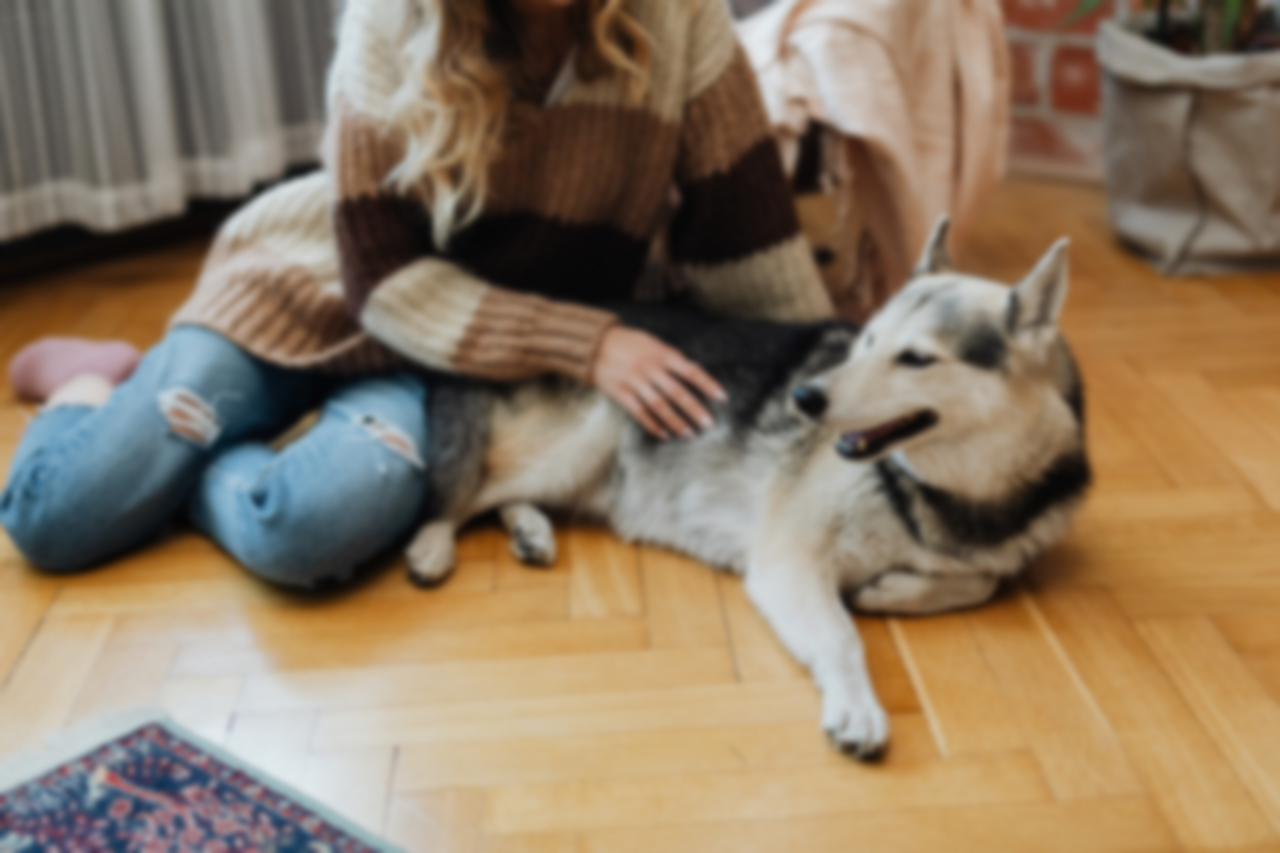

In [20]:
blur_image = np.asarray(image.filter(ImageFilter.GaussianBlur(radius=3)))
display(Image.fromarray(blur_image))

> Create a invert of the three channel mask created the previous steps.

In [21]:
mask_array_three_channel_invert = 1-mask_array_three_channel

> Check if the range of mask is 0 to 1

In [22]:
np.min(mask_array_three_channel_invert), np.max(mask_array_three_channel_invert)

(0, 1)

> Check if the shapes are right

In [23]:
blur_image.shape

(853, 1280, 3)

In [24]:
mask_array_three_channel_invert.shape

(853, 1280, 3)

> Element wise multiply the invert mask and blurred image. This will give an image where the blurred background of the selected object will be present and the pixels associate with the object of interest will be blank/black/value=0

In [25]:
blur_image_reverse_mask = blur_image*mask_array_three_channel_invert

> Check if the range of blur image reverse mask is 0 to 255

In [26]:
np.max(blur_image_reverse_mask), np.min(blur_image_reverse_mask)

(239, 0)

> Add up the segmented image and reverse segmented (blurred background portion). This will give the desired portrait photo looking output.

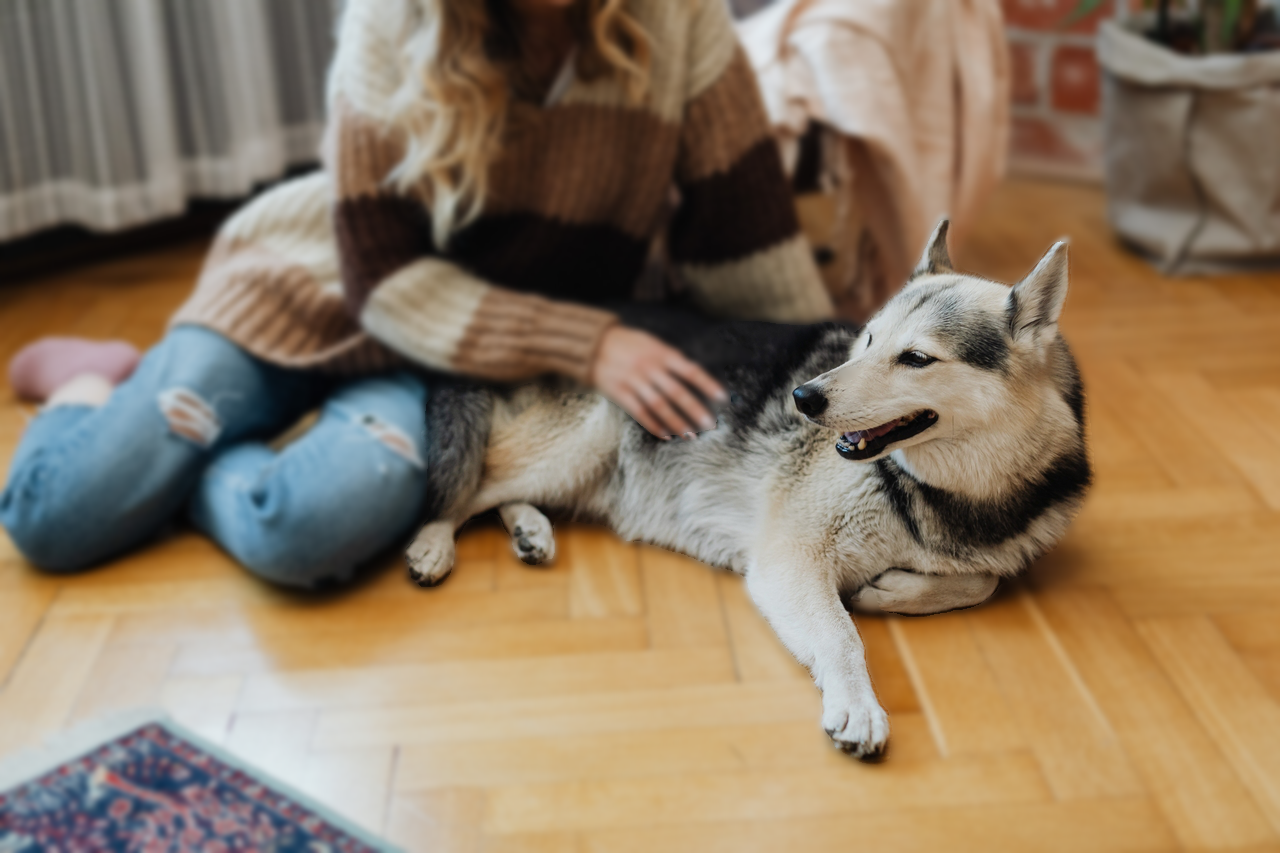

In [27]:
portrait_image = Image.fromarray((blur_image_reverse_mask).astype(np.uint8)+segmented_image.astype(np.uint8))
display(portrait_image)

> Let's see how it looks if we smooth out the image a little bit so that the edges are not that sharp.

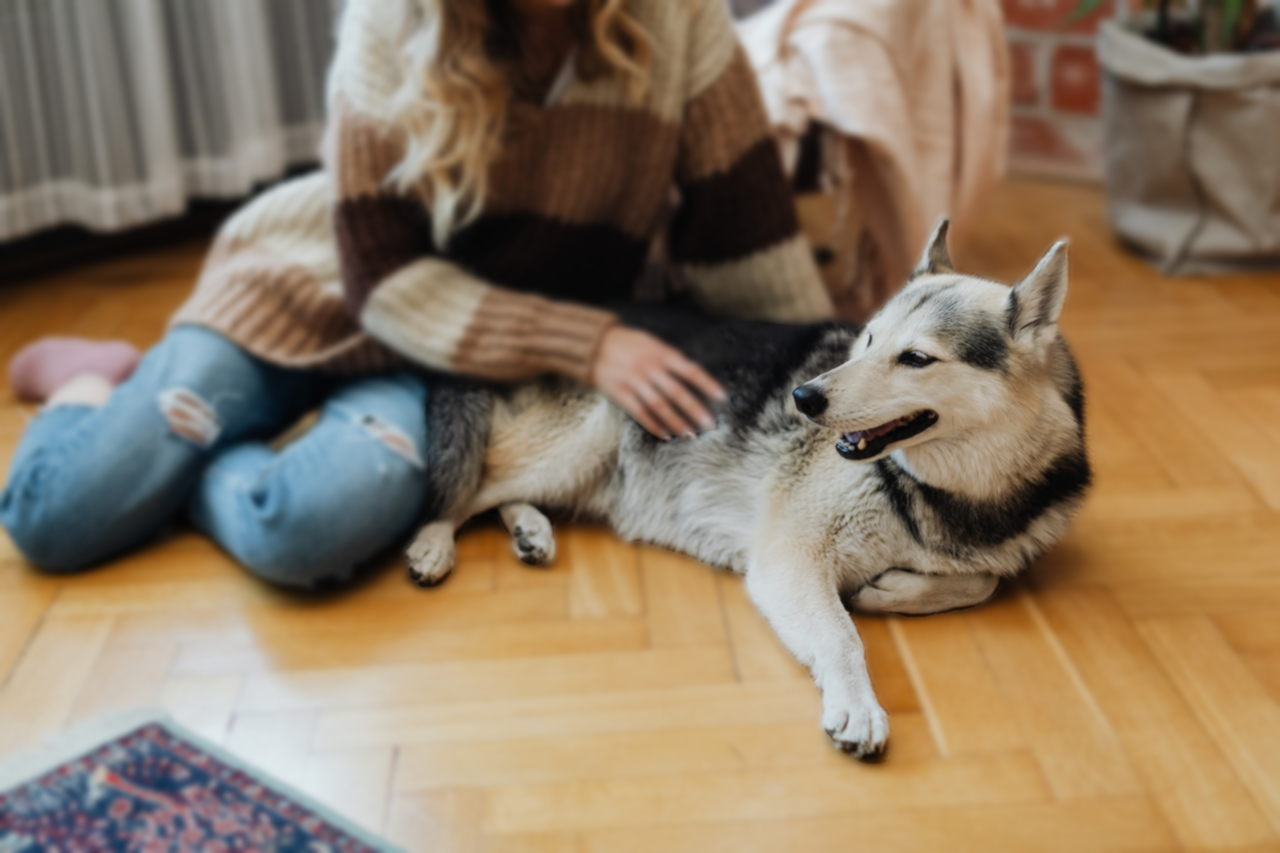

In [29]:
smoothenedImage = portrait_image.filter(ImageFilter.SMOOTH)
display(smoothenedImage)

Finally, we can see that we accomplished the kind of result we were hoping for. 

**Some Consideration:**
- Images were read using Pillow(PIL). And the displayed images are also a PIL.Image.Image object.
- The model gives the mask output as PIL.Image.Image object.
- For some of the transformation of the image we need to convert the image to an array using `np.asarray` function.
- So, anytime we displayed an image, we need to convert the array to PIL image by using `Image.fromarray`. Be sure to use .astype(np.uint8) in order to keep everything error free.